# Metrics & Plotting

You can read in the output of the previous LigandMPNN example to use as input data.

In [1]:
import sys
sys.path.append("..") # add the path to the protflow directory (e.g. /home/username/ProtSlurm)
from protflow.poses import Poses
from protflow.tools.esmfold import ESMFold
from protflow.jobstarters import LocalJobStarter, SbatchArrayJobstarter
import protflow.tools.metrics.rmsd as rmsd_metrics

slurm_gpu_jobstarter = SbatchArrayJobstarter(max_cores=10, gpus=1)
slurm_cpu_jobstarter = SbatchArrayJobstarter(max_cores=10, gpus=False)
local_jobstarter = LocalJobStarter(max_cores=1)

my_poses = Poses(poses="data/example_output/ligandmpnn_options/ligandmpnn_options_scores.csv", work_dir='metrics_plotting_example')

First, we generate predictions of our MPNN_derived sequences with ESMFold. We are interested how much the predicted structure deviates from the original backbone, so we calculate the Calpha RMSD compared to the input poses.

In [3]:
# run esmfold
esmfold = ESMFold(jobstarter=slurm_gpu_jobstarter)
my_poses = esmfold.run(poses=my_poses, prefix='esm_pred')
display(my_poses.df)

# calculate rmsd
bb_rmsd_runner = rmsd_metrics.BackboneRMSD(ref_col='input_poses', atoms=['CA'], jobstarter=local_jobstarter)
my_poses = bb_rmsd_runner.run(poses=my_poses, prefix='CA_rmsd', overwrite=False)

display(my_poses.df)

sbatch: defined options
sbatch: -------------------- --------------------
sbatch: array               : 1-10%10
sbatch: cpus-per-task       : 2
sbatch: error               : /home/tripp/ProtFlow/examples/metrics_plotting_example/esm_pred//ESMFold_4425535_slurm.err
sbatch: gpus-per-node       : 1
sbatch: job-name            : ESMFold_4425535
sbatch: output              : /home/tripp/ProtFlow/examples/metrics_plotting_example/esm_pred//ESMFold_4425535_slurm.out
sbatch: verbose             : 3
sbatch: wrap                : eval `sed -n ${SLURM_ARRAY_TASK_ID}p /home/tripp/ProtFlow/examples/metrics_plotting_example/esm_pred//ESMFold_4425535_cmds`
sbatch: -------------------- --------------------
sbatch: end of defined options
sbatch: debug:  propagating RLIMIT_CPU=18446744073709551615
sbatch: debug:  propagating RLIMIT_FSIZE=18446744073709551615
sbatch: debug:  propagating RLIMIT_DATA=18446744073709551615
sbatch: debug:  propagating RLIMIT_STACK=67108864
sbatch: debug:  propagating RLIMIT_C

To visualize our output, we can use the ProtFlow plotting functionalities.

Plot saved as metrics_plotting_example/scatterplot.png


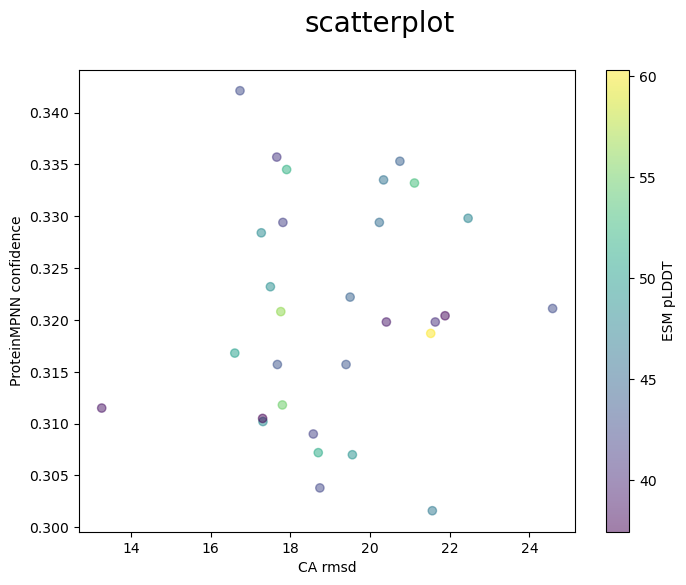

/home/tripp/ProtFlow/protflow/utils/plotting.py:216: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


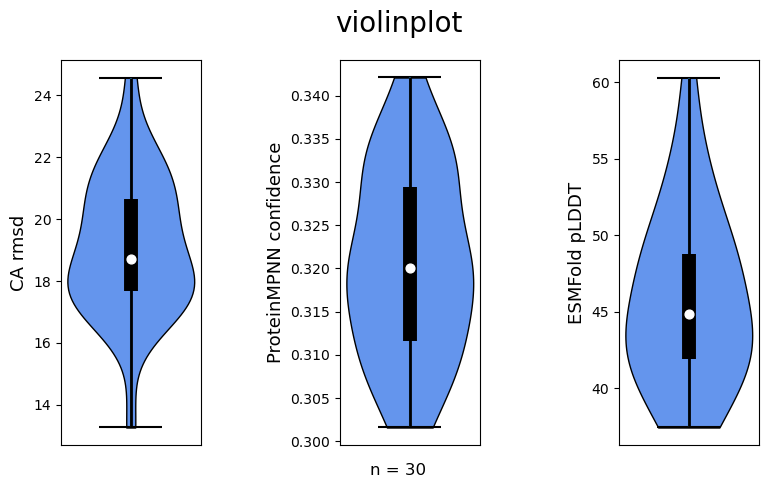

In [3]:
from protflow.utils.plotting import scatterplot, violinplot_multiple_cols

#my_poses = Poses(poses='data/example_output/metrics_plotting_example/metrics_plotting_example_scores.json', work_dir='metrics_plotting_examples')

scatterplot(dataframe=my_poses.df, x_column='CA_rmsd_rmsd', y_column='options_local_overall_confidence', labels=['CA rmsd', 'ProteinMPNN confidence', 'ESM pLDDT'], color_column='esm_pred_plddt', title='scatterplot', out_path='metrics_plotting_example/scatterplot.png')
violinplot_multiple_cols(dataframe=my_poses.df, cols=['CA_rmsd_rmsd', 'options_local_overall_confidence', 'esm_pred_plddt'], title='violinplot', y_labels=['CA rmsd', 'ProteinMPNN confidence', 'ESMFold pLDDT'], out_path='metrics_plotting_example/violinplot.png')

We can also create sequence logos of the sequences that were generated for each input backbone. sequence_logo accepts a dataframe column containing sequences or paths to fasta files as input. The logos will be saved in EPS format and can be viewed using document viewers.

In [3]:
from protflow.utils.plotting import sequence_logo
import os

#my_poses = Poses(poses='data/example_output/metrics_plotting_example/metrics_plotting_example_scores.json', work_dir='metrics_plotting_examples')

for input_pdb, df in my_poses.df.groupby('input_poses'):
    sequence_logo(dataframe=df, input_col='options_local_sequence', out_path=f'metrics_plotting_example/sequence_logo_{os.path.basename(input_pdb)}.logo')